In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch
from torch.nn import Sequential, ReLU, Linear, Conv1d, LSTM, RNN, Dropout
from torch.nn import Module
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor   
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from NCP.model import DeepSVD
from NCP.layers import SingularLayer, MLPOperator

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 10000
Nval = 1000
Ntest = 1000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# homoscedastic

In [14]:
X = np.random.uniform(0, 5, Ntrain+Nval+Ntest)
Y = np.zeros(X.shape[0])
for i, xi in enumerate(X):
    #Y[i] = xi**2 + np.random.normal(0, 1+xi)
    Y[i] = xi**2 + np.random.normal(0, 1)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()
# Xtransformed = X - X.mean()
# Ytransformed = Y - Y.mean()

Xtransformed = xscaler.fit_transform(X)
Ytransformed = yscaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(Xtransformed, Ytransformed, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [28]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 2
n_hidden = 2
layer_size = 4 # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(2e3), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

tensor([0.6361, 0.9840], grad_fn=<SqrtBackward0>)
sing val tensor([9.8209e-01, 8.3281e-09], grad_fn=<LinalgSvdBackward0>)
[[ 1.4969636   1.6826088   2.0318973  ...  2.098554    1.2032156
  -1.1999372 ]
 [ 1.6826088   1.8912767   2.283882   ...  2.3588052   1.3524318
  -1.3487468 ]
 [ 2.0318973   2.283882    2.757987   ...  2.8484633   1.6331794
  -1.6287296 ]
 ...
 [ 2.098554    2.3588052   2.8484633  ...  2.9419076   1.6867563
  -1.6821604 ]
 [ 1.2032156   1.3524318   1.6331794  ...  1.6867563   0.96710944
  -0.9644744 ]
 [-1.1999372  -1.3487468  -1.6287296  ... -1.6821604  -0.9644744
   0.96184653]]
U(x) [[-1.32683408e+00  1.05189933e-07]
 [-1.39353061e+00  1.40612826e-07]
 [-1.98596859e+00  1.52416220e-07]
 ...
 [-1.86766422e+00  1.35155190e-07]
 [-1.01883590e+00  1.04746995e-07]
 [ 9.29543197e-01 -8.52494821e-08]]
V(y) [[-1.2235047e+00 -2.3603910e-08]
 [-1.3752370e+00 -5.8983076e-09]
 [-1.6607188e+00  9.8618713e-09]
 ...
 [-1.7151990e+00  1.0121411e-08]
 [-9.8341721e-01 -4.3740762e

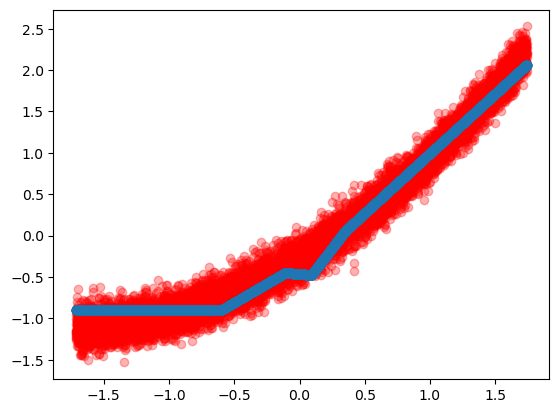

In [31]:
pred = reg.predict(X_train).reshape(-1, 1)

plt.scatter(X_train, Y_train, color='r', alpha=0.3)
plt.scatter(X_train, pred, alpha=0.5)
plt.show()

# Heteroscedastic

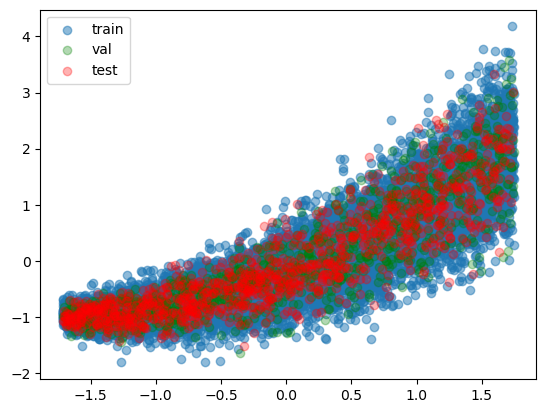

In [35]:
X = np.random.uniform(0, 5, Ntrain+Nval+Ntest)
Y = np.zeros(X.shape[0])
for i, xi in enumerate(X):
    Y[i] = xi**2 + np.random.normal(0, 1+xi)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()
# Xtransformed = X - X.mean()
# Ytransformed = Y - Y.mean()

Xtransformed = xscaler.fit_transform(X)
Ytransformed = yscaler.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(Xtransformed, Ytransformed, test_size=Ntest, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=Nval, random_state=0)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 1999, loss = -1.6371426582336426: 100%|██████████| 2000/2000 [00:07<00:00, 274.40it/s]


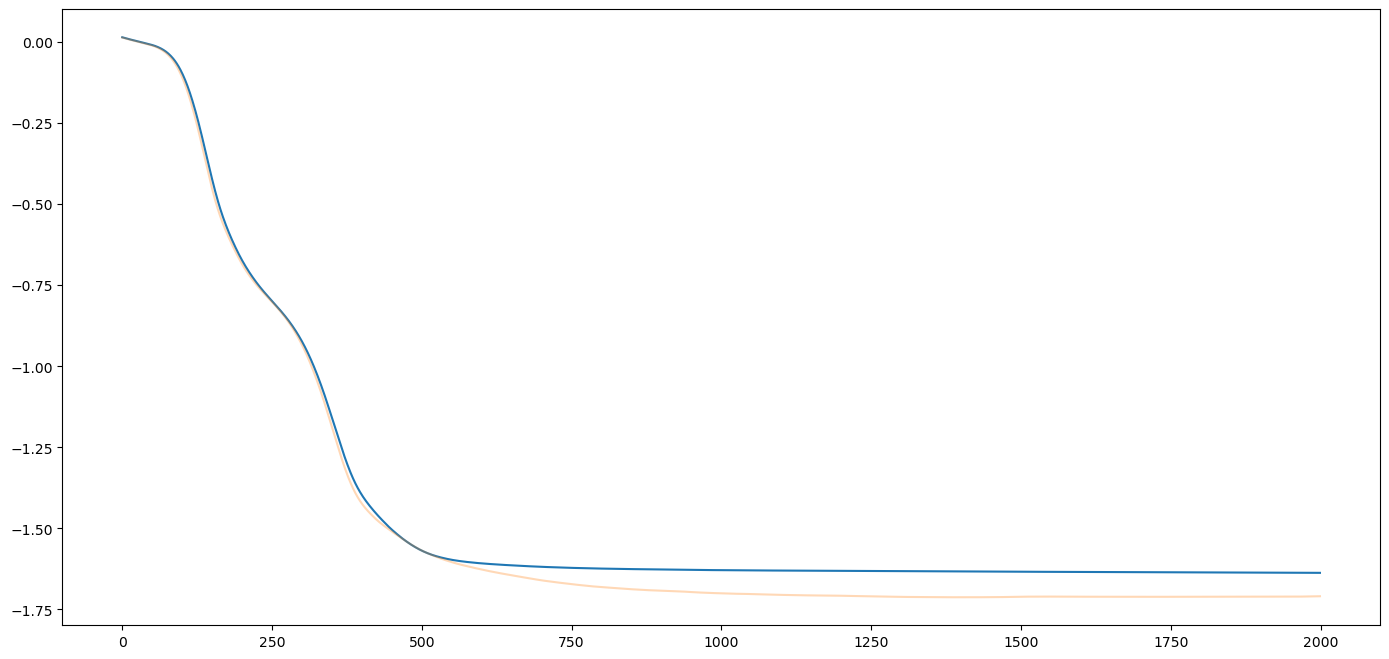

In [37]:
np.random.seed(0)
torch.manual_seed(0)

input_shape = X_train.shape[-1]
output_shape = 2
n_hidden = 2
layer_size = 4 # layer size of hidden layers.

U_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)
V_operator = MLPOperator(input_shape, n_hidden, layer_size, output_shape)

optimizer = Adam
optimizer_kwargs = {
    'lr': 1e-3
    }
reg = (DeepSVD(U_operator, V_operator, output_shape, gamma=0.))

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(2e3), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()

tensor([0.6334, 0.9807], grad_fn=<SqrtBackward0>)
sing val tensor([8.8614e-01, 3.1824e-08], grad_fn=<LinalgSvdBackward0>)
[[ 0.43448392 -0.8776065   0.28630388 ...  0.6562045   0.4862877
  -0.05972671]
 [-0.8776065   1.7726623  -0.57830024 ... -1.3254561  -0.98224413
   0.12064094]
 [ 0.28630388 -0.57830024  0.1886604  ...  0.43240705  0.32044008
  -0.03935701]
 ...
 [ 0.6562045  -1.3254561   0.43240705 ...  0.991071    0.7344442
  -0.09020573]
 [ 0.4862877  -0.98224413  0.32044008 ...  0.7344442   0.54426813
  -0.06684797]
 [-0.05972671  0.12064094 -0.03935701 ... -0.09020573 -0.06684797
   0.00821038]]
U(x) [[ 1.2013656e+00 -1.1257257e-07]
 [-1.3405640e+00  1.3255800e-07]
 [ 1.8387550e-01 -1.5405483e-08]
 ...
 [ 1.2676440e+00 -1.2070680e-07]
 [ 1.5859939e-01 -1.3231483e-08]
 [-4.2733979e-01  4.1873246e-08]]
V(y) [[ 6.59153938e-01  7.77381075e-08]
 [-1.33141363e+00 -1.83074576e-07]
 [ 4.34350550e-01  5.54551072e-08]
 ...
 [ 9.95525479e-01  1.39456745e-07]
 [ 7.37745285e-01  1.07466285

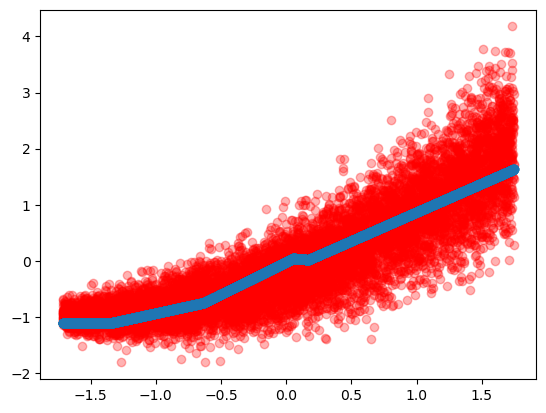

In [38]:
pred = reg.predict(X_train).reshape(-1, 1)

plt.scatter(X_train, Y_train, color='r', alpha=0.3)
plt.scatter(X_train, pred, alpha=0.5)
plt.show()